<a href="https://colab.research.google.com/github/Yatz1403/TB-Detection-Using-CDAM/blob/main/TB_DetectionFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTING MODELS:


In [ ]:
import keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, MaxPool2D
from keras.layers import Lambda # Import Lambda directly from keras.layers
from keras.preprocessing import image
from tensorflow.keras import datasets, layers, models, losses
from tensorflow.keras.models import Model, Sequential
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import *
from keras.models import load_model
#from keras.layers.core import Lambda # No longer needed
import os
from keras.layers import *
from sklearn.model_selection import KFold, StratifiedKFold
from keras.backend import int_shape
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Add, Activation, Lambda, Average
from keras import backend as K
from keras.activations import sigmoid
from keras.backend import sigmoid
# Import get_custom_objects from the correct module in TensorFlow 2.0+
from tensorflow.keras.utils import get_custom_objects
from keras.layers import Activation
from tensorflow.python.ops.gen_math_ops import mul
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


USING CDAM NET:

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_41 (Conv2D)          (None, 224, 224, 32)         896       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_20 (Ba  (None, 224, 224, 32)         128       ['conv2d_41[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_46 (Activation)  (None, 224, 224, 32)         0         ['batch_normalization_20

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


38/38 [==============================] - 60s 1s/step - loss: 0.2817 - acc: 0.9000 - val_loss: 2.7471 - val_acc: 0.5100 - lr: 0.0010
Epoch 2/30
38/38 [==============================] - ETA: 0s - loss: 0.1280 - acc: 0.9567
Epoch 2: acc improved from 0.90000 to 0.95667, saving model to CDAM_Net.hdf5
38/38 [==============================] - 47s 1s/step - loss: 0.1280 - acc: 0.9567 - val_loss: 9.2780 - val_acc: 0.5000 - lr: 0.0010
Epoch 3/30
38/38 [==============================] - ETA: 0s - loss: 0.0636 - acc: 0.9800
Epoch 3: acc improved from 0.95667 to 0.98000, saving model to CDAM_Net.hdf5
38/38 [==============================] - 48s 1s/step - loss: 0.0636 - acc: 0.9800 - val_loss: 4.2164 - val_acc: 0.5000 - lr: 0.0010
Epoch 4/30
38/38 [==============================] - ETA: 0s - loss: 0.1632 - acc: 0.9400
Epoch 4: acc did not improve from 0.98000
38/38 [==============================] - 47s 1s/step - loss: 0.1632 - acc: 0.9400 - val_loss: 1.0979 - val_acc: 0.6300 - lr: 0.0010
Epoch 5/3

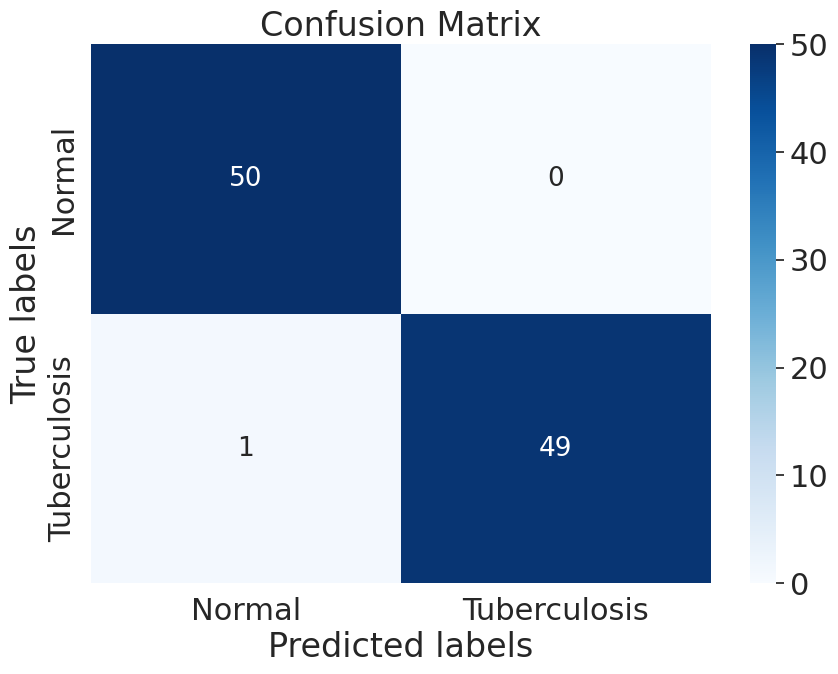

Classification Report
              precision    recall  f1-score   support

      Normal       0.98      1.00      0.99        50
Tuberculosis       1.00      0.98      0.99        50

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



In [ ]:
import os
import cv2  # OpenCV library for image processing
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, DepthwiseConv2D, AveragePooling2D, Lambda, Reshape, Permute
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import matplotlib.pyplot as plt

# Define swish activation function
def swish(x, beta=1):
    return x * tf.keras.activations.sigmoid(beta * x)

get_custom_objects().update({'swish': Activation(swish)})

# Define channel shuffle function
def channel_shuffle(x, groups):
    _, width, height, channels = x.get_shape().as_list()
    group_ch = channels // groups
    x = Reshape([width, height, group_ch, groups])(x)
    x = Permute([1, 2, 4, 3])(x)
    x = Reshape([width, height, channels])(x)
    return x

# Define MFR block
def conv_module(x, k):
    a = Conv2D(k, (1, 1), padding='same')(x)
    a = BatchNormalization()(a)
    a = Activation('swish')(a)

    y = Conv2D(k // 2, (3, 3), padding='same')(x)
    y = BatchNormalization()(y)
    y = Activation('swish')(y)
    y = Conv2D(k // 2, (3, 3), padding='same')(y)
    y = BatchNormalization()(y)
    y = Activation('swish')(y)

    z = Conv2D(k, (3, 3), padding='same')(x)
    z = BatchNormalization()(z)
    z = Activation('swish')(z)

    c = tf.keras.layers.Concatenate()([y, z])

    d = DepthwiseConv2D(3, padding='same')(c)
    d = BatchNormalization()(d)
    d = Activation('swish')(d)
    x = tf.keras.layers.Concatenate()([d, c])
    x = tf.keras.layers.Concatenate()([x, a])
    x = Conv2D(k, (1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)

    return x

# Define CSDA block
def CSDA(inputs):
    shape = tf.keras.backend.int_shape(inputs)
    x = MaxPooling2D(pool_size=(shape[1], shape[2]))(inputs)
    x = Conv2D(shape[3] // 4, 1, padding='same')(x)
    x = Activation('swish')(x)
    x = Conv2D(shape[3], 1, padding='same')(x)
    x = Activation('sigmoid')(x)

    y = AveragePooling2D(pool_size=(shape[1], shape[2]))(inputs)
    y = Conv2D(shape[3] // 4, 1, padding='same')(y)
    y = Activation('swish')(y)
    y = Conv2D(shape[3], 1, padding='same')(y)
    y = Activation('sigmoid')(y)

    z = tf.keras.layers.Average()([x, y])
    C_A = tf.math.multiply(z, inputs)

    a = Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(inputs)
    a = Conv2D(shape[3] // shape[3], 1, padding='same')(a)
    a = Activation('sigmoid')(a)

    b = Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(inputs)
    b = Conv2D(shape[3] // shape[3], 1, padding='same')(b)
    b = Activation('sigmoid')(b)

    c = tf.keras.layers.Average()([a, b])
    S_A = tf.math.multiply(c, inputs)
    v = tf.keras.layers.Add()([C_A, S_A])
    d = channel_shuffle(inputs, 8)
    x = tf.keras.layers.Add()([v, d])

    return x

# Define the base model
# Define the base model with an additional Dense layer for classification
def get_base_model():
    input_shape = (224, 224, 3)
    inputs = Input(shape=input_shape)
    x = Conv2D(32, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    x = MaxPooling2D()(x)
    x = conv_module(x, 64) #mfr
    x = MaxPooling2D()(x)
    x = CSDA(x)
    x = conv_module(x, 128)
    x = MaxPooling2D()(x)
    x = CSDA(x)
    x = conv_module(x, 256)
    x = MaxPooling2D()(x)
    x = CSDA(x)
    x = Conv2D(256, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    x = MaxPooling2D()(x)
    x = CSDA(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='swish')(x)  # Optional dense layer before the final output layer
    outputs = Dense(2, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

# Compile the model
model = get_base_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

# Define directories
file_listNormal = "/content/drive/MyDrive/TB_Detection/TB_Chest_Radiography_Database/Normal"
file_listTB = "/content/drive/MyDrive/TB_Detection/TB_Chest_Radiography_Database/Tuberculosis"

# Function to load and resize images
def load_and_resize_images(directory, input_shape, limit=None):
    images = []
    count = 0
    for file_name in os.listdir(directory):
        if limit is not None and count >= limit:
            break
        file_path = os.path.join(directory, file_name)
        image = cv2.imread(file_path, cv2.IMREAD_COLOR)  # Read the image
        if image is not None:
            image = cv2.resize(image, (input_shape[0], input_shape[1]))  # Resize to model input shape
            images.append(image)
            count += 1
    return np.array(images), count

# Load and resize images
input_shape = (224, 224)
normal_images, count_normal = load_and_resize_images(file_listNormal, input_shape, limit=350)
print(f"Number of normal images loaded: {count_normal}")

tuberculosis_images, count_tb = load_and_resize_images(file_listTB, input_shape, limit = 350)
print(f"Number of tuberculosis images loaded: {count_tb}")

# Perform train-test split for normal images: 500 for training, 200 for testing
X_normal_train, X_normal_test = train_test_split(normal_images, test_size=50, random_state=42)

# Perform train-test split for tuberculosis images: 500 for training, 200 for testing
X_tuberculosis_train, X_tuberculosis_test = train_test_split(tuberculosis_images, test_size=50, random_state=42)

# Ensure the training data for both normal and tuberculosis contains only 500 images each
X_train = np.vstack((X_normal_train[:300], X_tuberculosis_train[:300]))
X_test = np.vstack((X_normal_test, X_tuberculosis_test))

# Create labels for training and testing datasets
y_train = np.array([0] * 300 + [1] * 300)
y_test = np.array([0] * 50 + [1] * 50)

# Convert labels to categorical
y_train = tf.keras.utils.to_categorical(y_train, 2)
y_test = tf.keras.utils.to_categorical(y_test, 2)

# Training and testing the model
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.4, patience=5, min_lr=0.00001)
filepath = "CDAM_Net.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [reduce_lr, checkpoint]

history = model.fit(X_train, y_train, epochs=30, batch_size=16, callbacks=callbacks_list, validation_data=(X_test, y_test))
results = model.evaluate(X_test, y_test, batch_size=16)

# Predictions and evaluation
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Confusion matrix
matrix = confusion_matrix(true_classes, y_pred)
plt.figure(figsize=(10, 7))
names = ["Normal", "Tuberculosis"]
group_counts = ["{0:0.0f}".format(value) for value in matrix.flatten()]
labels = [f"{v1}" for v1 in group_counts]
labels = np.asarray(labels).reshape(2, 2)
sn.set(font_scale=2)
sn.heatmap(matrix, annot=labels, fmt='', xticklabels=names, yticklabels=names, annot_kws={"size": 19}, cmap='Blues')
plt.yticks(rotation=90)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title('Confusion Matrix')
plt.savefig('confusioncdam.png', dpi=1080)
plt.show()

# Classification report
print('Classification Report')
target_names = ['Normal', 'Tuberculosis']
print(classification_report(true_classes, y_pred, target_names=target_names))

USING VGG16 MODEL:

Number of normal images loaded: 350
Number of tuberculosis images loaded: 350
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                               

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


38/38 [==============================] - 15s 359ms/step - loss: 0.1558 - acc: 0.9383 - val_loss: 0.5556 - val_acc: 0.8400 - lr: 0.0010
Epoch 2/25
38/38 [==============================] - ETA: 0s - loss: 0.0330 - acc: 0.9833
Epoch 2: acc improved from 0.93833 to 0.98333, saving model to VGG16_TB_Detection.hdf5
38/38 [==============================] - 13s 354ms/step - loss: 0.0330 - acc: 0.9833 - val_loss: 0.2055 - val_acc: 0.9100 - lr: 0.0010
Epoch 3/25
38/38 [==============================] - ETA: 0s - loss: 0.0326 - acc: 0.9883
Epoch 3: acc improved from 0.98333 to 0.98833, saving model to VGG16_TB_Detection.hdf5
38/38 [==============================] - 14s 357ms/step - loss: 0.0326 - acc: 0.9883 - val_loss: 0.1221 - val_acc: 0.9500 - lr: 0.0010
Epoch 4/25
38/38 [==============================] - ETA: 0s - loss: 0.0091 - acc: 0.9983
Epoch 4: acc improved from 0.98833 to 0.99833, saving model to VGG16_TB_Detection.hdf5
38/38 [==============================] - 13s 355ms/step - loss: 0.0

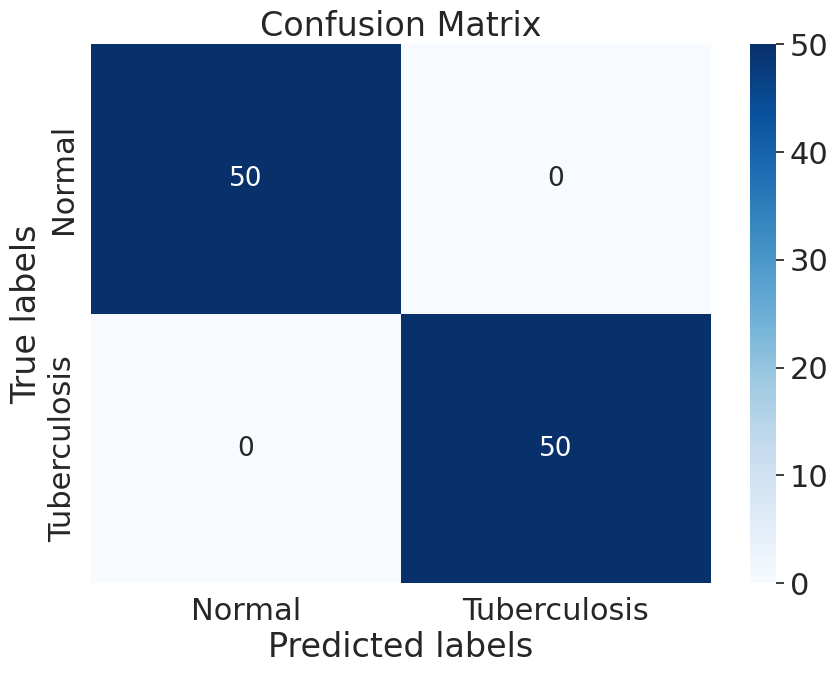

Classification Report
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        50
Tuberculosis       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_input_vgg

import os
import cv2  # OpenCV library for image processing
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import VGG16
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import matplotlib.pyplot as plt

# Define directories
file_listNormal = "/content/drive/MyDrive/TB_Detection/TB_Chest_Radiography_Database/Normal"
file_listTB = "/content/drive/MyDrive/TB_Detection/TB_Chest_Radiography_Database/Tuberculosis"

# Function to load and resize images
def load_and_resize_images(directory, input_shape, limit=None):
    images = []
    count = 0
    for file_name in os.listdir(directory):
        if limit is not None and count >= limit:
            break
        file_path = os.path.join(directory, file_name)
        image = cv2.imread(file_path, cv2.IMREAD_COLOR)  # Read the image
        if image is not None:
            image = cv2.resize(image, (input_shape[0], input_shape[1]))  # Resize to model input shape
            images.append(image)
            count += 1
    return np.array(images), count

# Load and resize images
input_shape = (224, 224)
normal_images, count_normal = load_and_resize_images(file_listNormal, input_shape, limit=350)
print(f"Number of normal images loaded: {count_normal}")

tuberculosis_images, count_tb = load_and_resize_images(file_listTB, input_shape, limit = 350)
print(f"Number of tuberculosis images loaded: {count_tb}")

# Perform train-test split for normal images
X_normal_train, X_normal_test = train_test_split(normal_images, test_size=50, random_state=42)

# Perform train-test split for tuberculosis images
X_tuberculosis_train, X_tuberculosis_test = train_test_split(tuberculosis_images, test_size=50, random_state=42)

# Ensure the training data for both normal and tuberculosis contains only 300 images each
X_train = np.vstack((X_normal_train[:300], X_tuberculosis_train[:300]))
X_test = np.vstack((X_normal_test, X_tuberculosis_test))

# Create labels for training and testing datasets
y_train = np.array([0] * 300 + [1] * 300)
y_test = np.array([0] * 50 + [1] * 50)

# Convert labels to categorical
y_train = tf.keras.utils.to_categorical(y_train, 2)
y_test = tf.keras.utils.to_categorical(y_test, 2)

# Define the VGG16 model
def get_vgg16_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model

# Compile the model
model = get_vgg16_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

# Training and testing the model
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.4, patience=5, min_lr=0.00001)
filepath = "VGG16_TB_Detection.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [reduce_lr, checkpoint]

history = model.fit(X_train, y_train, epochs=25, batch_size=16, callbacks=callbacks_list, validation_data=(X_test, y_test))
results = model.evaluate(X_test, y_test, batch_size=16)

# Predictions and evaluation
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Confusion matrix
matrix = confusion_matrix(true_classes, y_pred)
plt.figure(figsize=(10, 7))
names = ["Normal", "Tuberculosis"]
group_counts = ["{0:0.0f}".format(value) for value in matrix.flatten()]
labels = [f"{v1}" for v1 in group_counts]
labels = np.asarray(labels).reshape(2, 2)
sn.set(font_scale=2)
sn.heatmap(matrix, annot=labels, fmt='', xticklabels=names, yticklabels=names, annot_kws={"size": 19}, cmap='Blues')
plt.yticks(rotation=90)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title('Confusion Matrix')
plt.savefig('confusion_vgg16.png', dpi=1080)
plt.show()

# Classification report
print('Classification Report')
target_names = ['Normal', 'Tuberculosis']
print(classification_report(true_classes, y_pred, target_names=target_names))





VGG 16 MODEL

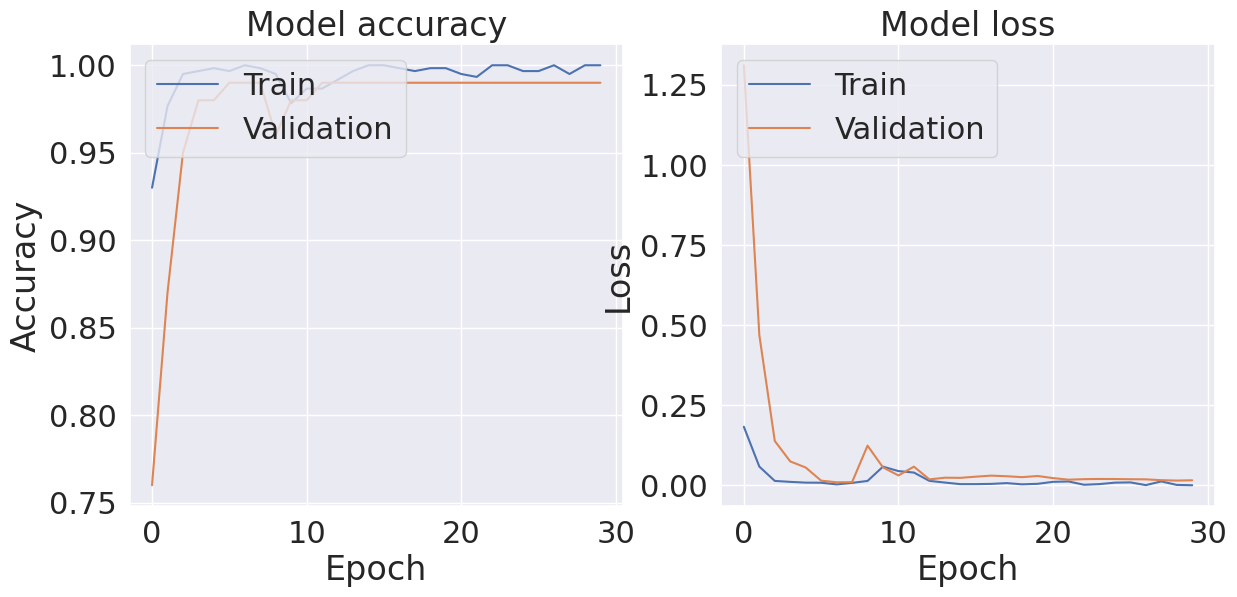

In [ ]:
# Import necessary libraries for plotting
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Save and show the plots
plt.savefig('training_validation_curves_vgg16.png', dpi=1080)
plt.show()


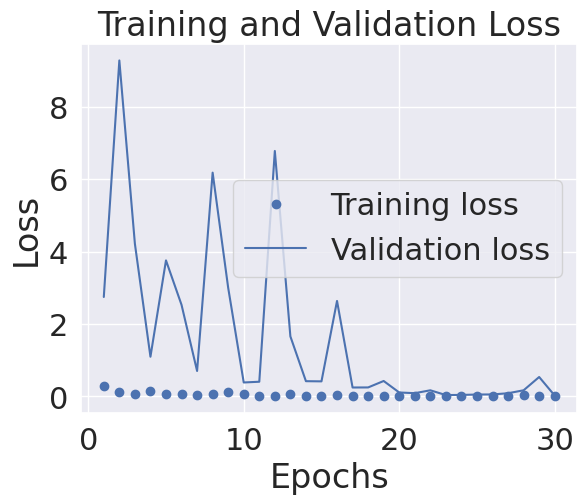

In [ ]:
import matplotlib.pyplot as plt

# Assuming history contains the training history of your model
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plotting training vs. validation loss
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

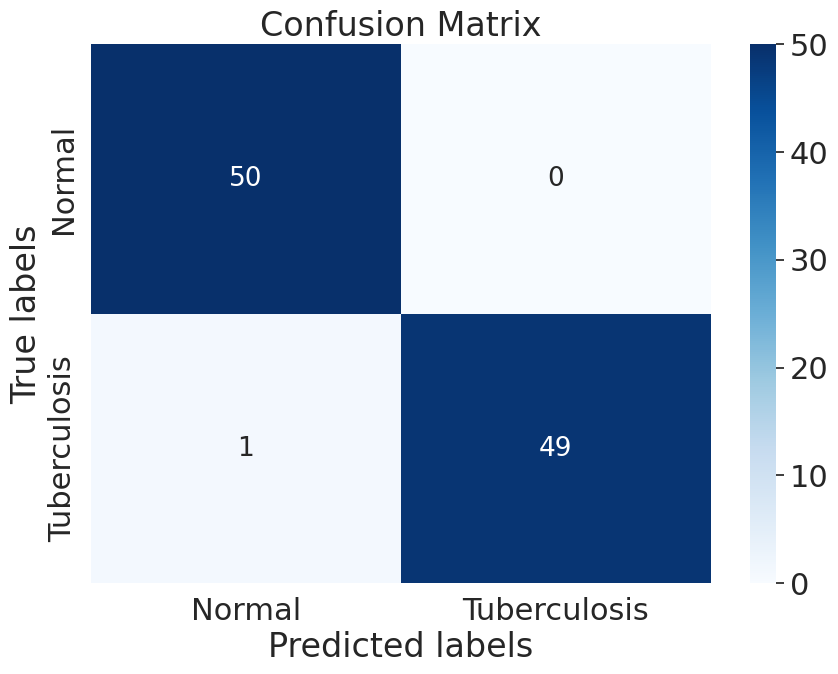

In [ ]:
matrix = confusion_matrix(true_classes, y_pred)
plt.figure(figsize=(10, 7))
names = ["Normal", "Tuberculosis"]
group_counts = ["{0:0.0f}".format(value) for value in matrix.flatten()]
labels = [f"{v1}" for v1 in group_counts]
labels = np.asarray(labels).reshape(2, 2)
sn.set(font_scale=2)
sn.heatmap(matrix, annot=labels, fmt='', xticklabels=names, yticklabels=names, annot_kws={"size": 19}, cmap='Blues')
plt.yticks(rotation=90)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title('Confusion Matrix')
plt.savefig('confusioncdam.png', dpi=1080)
plt.show()

USING MOBILENET:

17225924/17225924 [==============================] - 0s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                            

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


37/38 [============================>.] - ETA: 0s - loss: 0.1282 - acc: 0.9426
Epoch 2: acc improved from 0.87500 to 0.94333, saving model to MobileNet_TB_Detection.hdf5
38/38 [==============================] - 3s 89ms/step - loss: 0.1278 - acc: 0.9433 - val_loss: 0.2508 - val_acc: 0.9000 - lr: 0.0010
Epoch 3/25
38/38 [==============================] - ETA: 0s - loss: 0.0655 - acc: 0.9767
Epoch 3: acc improved from 0.94333 to 0.97667, saving model to MobileNet_TB_Detection.hdf5
38/38 [==============================] - 3s 88ms/step - loss: 0.0655 - acc: 0.9767 - val_loss: 0.3157 - val_acc: 0.8900 - lr: 0.0010
Epoch 4/25
37/38 [============================>.] - ETA: 0s - loss: 0.0752 - acc: 0.9764
Epoch 4: acc did not improve from 0.97667
38/38 [==============================] - 3s 86ms/step - loss: 0.0743 - acc: 0.9767 - val_loss: 0.2177 - val_acc: 0.9500 - lr: 0.0010
Epoch 5/25
37/38 [============================>.] - ETA: 0s - loss: 0.0683 - acc: 0.9831
Epoch 5: acc improved from 0.976

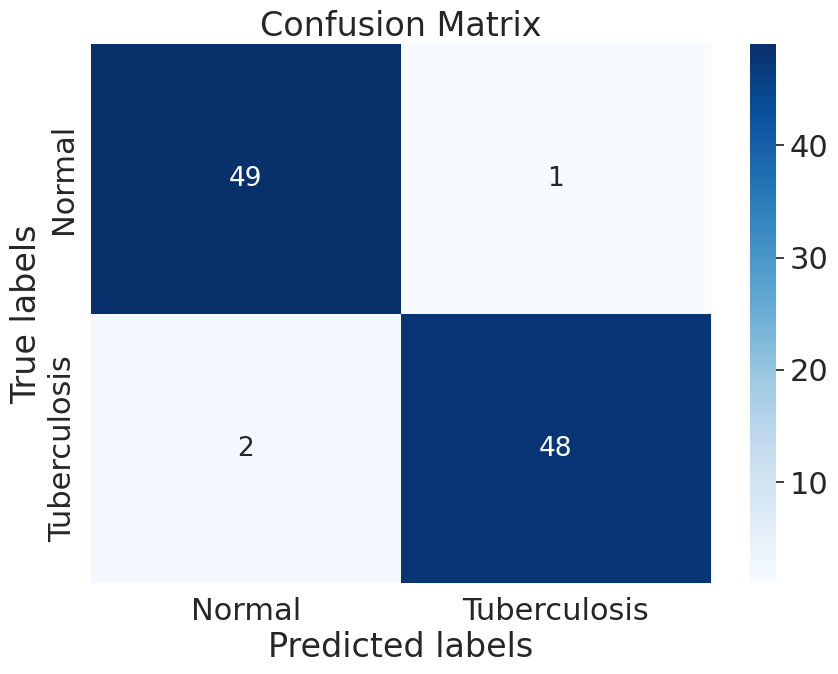

Classification Report
              precision    recall  f1-score   support

      Normal       0.96      0.98      0.97        50
Tuberculosis       0.98      0.96      0.97        50

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100



In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input as preprocess_input_mobilenet

# Define the MobileNet model
def get_mobilenet_model():
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Use GlobalAveragePooling instead of Flatten for MobileNet
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model

# Compile the model
model = get_mobilenet_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

# Training and testing the model
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.4, patience=5, min_lr=0.00001)
filepath = "MobileNet_TB_Detection.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [reduce_lr, checkpoint]

history = model.fit(X_train, y_train, epochs=25, batch_size=16, callbacks=callbacks_list, validation_data=(X_test, y_test))
results = model.evaluate(X_test, y_test, batch_size=16)

# Predictions and evaluation
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Confusion matrix
matrix = confusion_matrix(true_classes, y_pred)
plt.figure(figsize=(10, 7))
names = ["Normal", "Tuberculosis"]
group_counts = ["{0:0.0f}".format(value) for value in matrix.flatten()]
labels = [f"{v1}" for v1 in group_counts]
labels = np.asarray(labels).reshape(2, 2)
sn.set(font_scale=2)
sn.heatmap(matrix, annot=labels, fmt='', xticklabels=names, yticklabels=names, annot_kws={"size": 19}, cmap='Blues')
plt.yticks(rotation=90)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title('Confusion Matrix')
plt.savefig('confusion_mobilenet.png', dpi=1080)
plt.show()

# Classification report
print('Classification Report')
target_names = ['Normal', 'Tuberculosis']
print(classification_report(true_classes, y_pred, target_names=target_names))


USING RESNET50:

94765736/94765736 [==============================] - 0s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                       

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


38/38 [==============================] - 17s 344ms/step - loss: 0.2070 - acc: 0.9300 - val_loss: 1.3926 - val_acc: 0.6700 - lr: 0.0010
Epoch 2/25
38/38 [==============================] - ETA: 0s - loss: 0.0873 - acc: 0.9667
Epoch 2: acc improved from 0.93000 to 0.96667, saving model to ResNet50_TB_Detection.hdf5
38/38 [==============================] - 12s 313ms/step - loss: 0.0873 - acc: 0.9667 - val_loss: 0.6407 - val_acc: 0.8200 - lr: 0.0010
Epoch 3/25
38/38 [==============================] - ETA: 0s - loss: 0.0402 - acc: 0.9817
Epoch 3: acc improved from 0.96667 to 0.98167, saving model to ResNet50_TB_Detection.hdf5
38/38 [==============================] - 12s 322ms/step - loss: 0.0402 - acc: 0.9817 - val_loss: 0.3767 - val_acc: 0.9200 - lr: 0.0010
Epoch 4/25
38/38 [==============================] - ETA: 0s - loss: 0.0343 - acc: 0.9850
Epoch 4: acc improved from 0.98167 to 0.98500, saving model to ResNet50_TB_Detection.hdf5
38/38 [==============================] - 12s 315ms/step - 

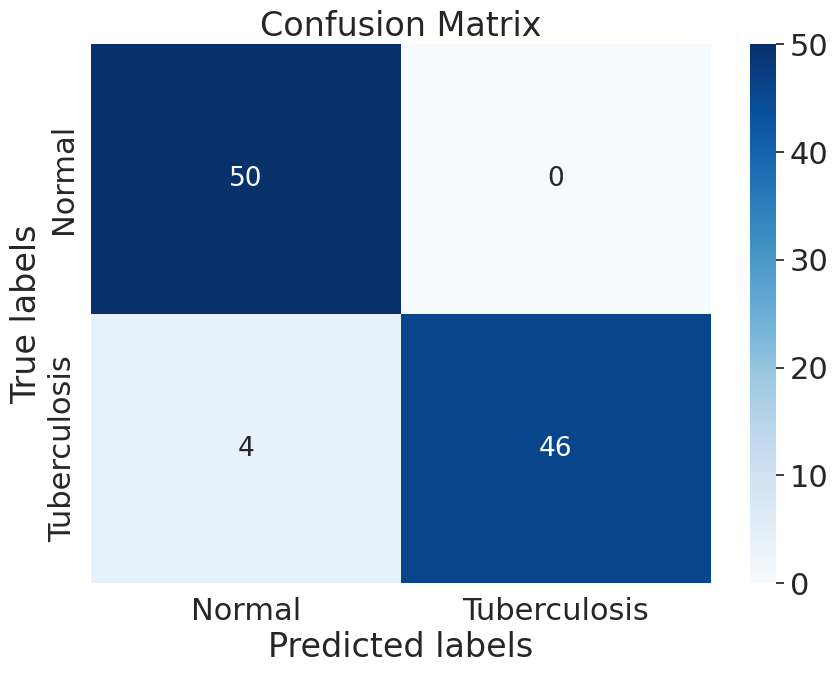

Classification Report
              precision    recall  f1-score   support

      Normal       0.93      1.00      0.96        50
Tuberculosis       1.00      0.92      0.96        50

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100



In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_resnet
from tensorflow.keras.layers import GlobalAveragePooling2D

# Define the ResNet50 model
def get_resnet50_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Use GlobalAveragePooling
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model

# Compile the model
model = get_resnet50_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

# Training and testing the model
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.4, patience=5, min_lr=0.00001)
filepath = "ResNet50_TB_Detection.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [reduce_lr, checkpoint]

history = model.fit(X_train, y_train, epochs=25, batch_size=16, callbacks=callbacks_list, validation_data=(X_test, y_test))
results = model.evaluate(X_test, y_test, batch_size=16)

# Predictions and evaluation
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Confusion matrix
matrix = confusion_matrix(true_classes, y_pred)
plt.figure(figsize=(10, 7))
names = ["Normal", "Tuberculosis"]
group_counts = ["{0:0.0f}".format(value) for value in matrix.flatten()]
labels = [f"{v1}" for v1 in group_counts]
labels = np.asarray(labels).reshape(2, 2)
sn.set(font_scale=2)
sn.heatmap(matrix, annot=labels, fmt='', xticklabels=names, yticklabels=names, annot_kws={"size": 19}, cmap='Blues')
plt.yticks(rotation=90)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title('Confusion Matrix')
plt.savefig('confusion_resnet50.png', dpi=1080)
plt.show()

# Classification report
print('Classification Report')
target_names = ['Normal', 'Tuberculosis']
print(classification_report(true_classes, y_pred, target_names=target_names))


USING ALEXNET MODEL:

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 56, 96)        34944     
                                                                 
 activation (Activation)     (None, 56, 56, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 96)        0         
 D)                                                              
                                                                 
 batch_normalization_8 (Bat  (None, 27, 27, 96)        384       
 chNormalization)                                                
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 activation_1 (Activation)   (None, 27, 27, 256)       0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


38/38 [==============================] - 16s 364ms/step - loss: 6.0421 - acc: 0.7800 - val_loss: 595.4025 - val_acc: 0.5000 - lr: 0.0010
Epoch 2/25
38/38 [==============================] - ETA: 0s - loss: 2.1277 - acc: 0.8667
Epoch 2: acc improved from 0.78000 to 0.86667, saving model to AlexNet_TB_Detection.hdf5
38/38 [==============================] - 17s 439ms/step - loss: 2.1277 - acc: 0.8667 - val_loss: 200.5929 - val_acc: 0.5000 - lr: 0.0010
Epoch 3/25
38/38 [==============================] - ETA: 0s - loss: 0.8323 - acc: 0.9100
Epoch 3: acc improved from 0.86667 to 0.91000, saving model to AlexNet_TB_Detection.hdf5
38/38 [==============================] - 13s 356ms/step - loss: 0.8323 - acc: 0.9100 - val_loss: 11.9087 - val_acc: 0.6700 - lr: 0.0010
Epoch 4/25
38/38 [==============================] - ETA: 0s - loss: 0.9465 - acc: 0.8733
Epoch 4: acc did not improve from 0.91000
38/38 [==============================] - 12s 303ms/step - loss: 0.9465 - acc: 0.8733 - val_loss: 13.470

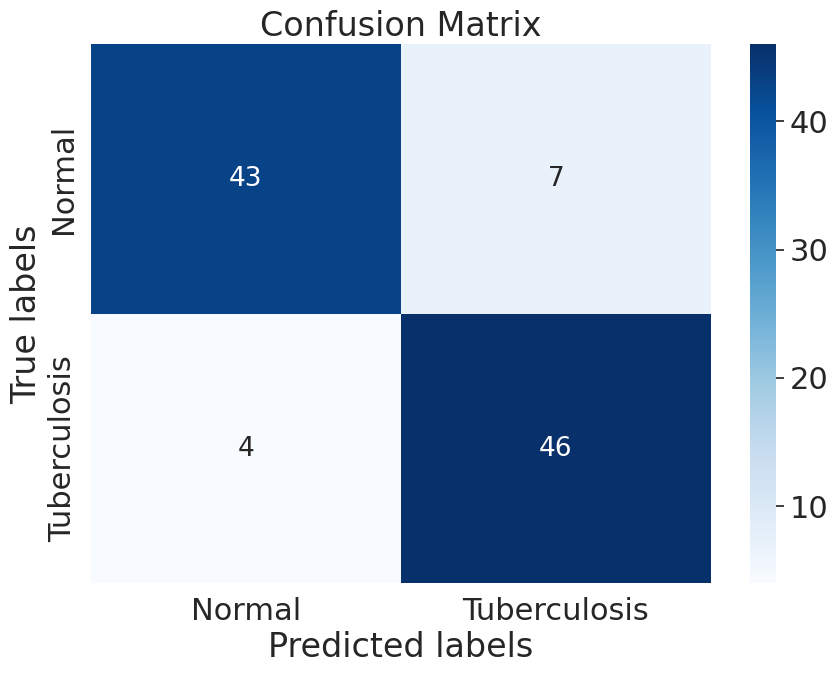

Classification Report
              precision    recall  f1-score   support

      Normal       0.91      0.86      0.89        50
Tuberculosis       0.87      0.92      0.89        50

    accuracy                           0.89       100
   macro avg       0.89      0.89      0.89       100
weighted avg       0.89      0.89      0.89       100



In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Activation

# Define the AlexNet model
def get_alexnet_model():
    model = Sequential()

    # Layer 1
    model.add(Conv2D(96, (11, 11), strides=4, input_shape=(224, 224, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(BatchNormalization())

    # Layer 2
    model.add(Conv2D(256, (5, 5), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(BatchNormalization())

    # Layer 3
    model.add(Conv2D(384, (3, 3), padding='same'))
    model.add(Activation('relu'))

    # Layer 4
    model.add(Conv2D(384, (3, 3), padding='same'))
    model.add(Activation('relu'))

    # Layer 5
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(BatchNormalization())

    # Flatten
    model.add(Flatten())

    # Layer 6
    model.add(Dense(4096))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    # Layer 7
    model.add(Dense(4096))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(2))
    model.add(Activation('softmax'))

    return model

# Compile the model
model = get_alexnet_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

# Training and testing the model
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.4, patience=5, min_lr=0.00001)
filepath = "AlexNet_TB_Detection.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [reduce_lr, checkpoint]

history = model.fit(X_train, y_train, epochs=25, batch_size=16, callbacks=callbacks_list, validation_data=(X_test, y_test))
results = model.evaluate(X_test, y_test, batch_size=16)

# Predictions and evaluation
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Confusion matrix
matrix = confusion_matrix(true_classes, y_pred)
plt.figure(figsize=(10, 7))
names = ["Normal", "Tuberculosis"]
group_counts = ["{0:0.0f}".format(value) for value in matrix.flatten()]
labels = [f"{v1}" for v1 in group_counts]
labels = np.asarray(labels).reshape(2, 2)
sn.set(font_scale=2)
sn.heatmap(matrix, annot=labels, fmt='', xticklabels=names, yticklabels=names, annot_kws={"size": 19}, cmap='Blues')
plt.yticks(rotation=90)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title('Confusion Matrix')
plt.savefig('confusion_alexnet.png', dpi=1080)
plt.show()

# Classification report
print('Classification Report')
target_names = ['Normal', 'Tuberculosis']
print(classification_report(true_classes, y_pred, target_names=target_names))


USING GoolNet (INCEPTION V1):

87910968/87910968 [==============================] - 0s 0us/step
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_5 (Conv2D)           (None, 111, 111, 32)         864       ['input_5[0][0]']             
                                                                                                  
 batch_normalization_11 (Ba  (None, 111, 111, 32)         96        ['conv2d_5[0][0]']            
 tchNormalization)                                                                                
                                                                                                  
 activation_8 (Activation) 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


38/38 [==============================] - 13s 219ms/step - loss: 0.3483 - acc: 0.8450 - val_loss: 3.5205 - val_acc: 0.5200 - lr: 0.0010
Epoch 2/25
38/38 [==============================] - ETA: 0s - loss: 0.2438 - acc: 0.9017
Epoch 2: acc improved from 0.84500 to 0.90167, saving model to InceptionV3_TB_Detection.hdf5
38/38 [==============================] - 7s 178ms/step - loss: 0.2438 - acc: 0.9017 - val_loss: 1.1945 - val_acc: 0.5900 - lr: 0.0010
Epoch 3/25
38/38 [==============================] - ETA: 0s - loss: 0.1793 - acc: 0.9233
Epoch 3: acc improved from 0.90167 to 0.92333, saving model to InceptionV3_TB_Detection.hdf5
38/38 [==============================] - 7s 180ms/step - loss: 0.1793 - acc: 0.9233 - val_loss: 1.9286 - val_acc: 0.5800 - lr: 0.0010
Epoch 4/25
38/38 [==============================] - ETA: 0s - loss: 0.1807 - acc: 0.9333
Epoch 4: acc improved from 0.92333 to 0.93333, saving model to InceptionV3_TB_Detection.hdf5
38/38 [==============================] - 7s 175ms/s

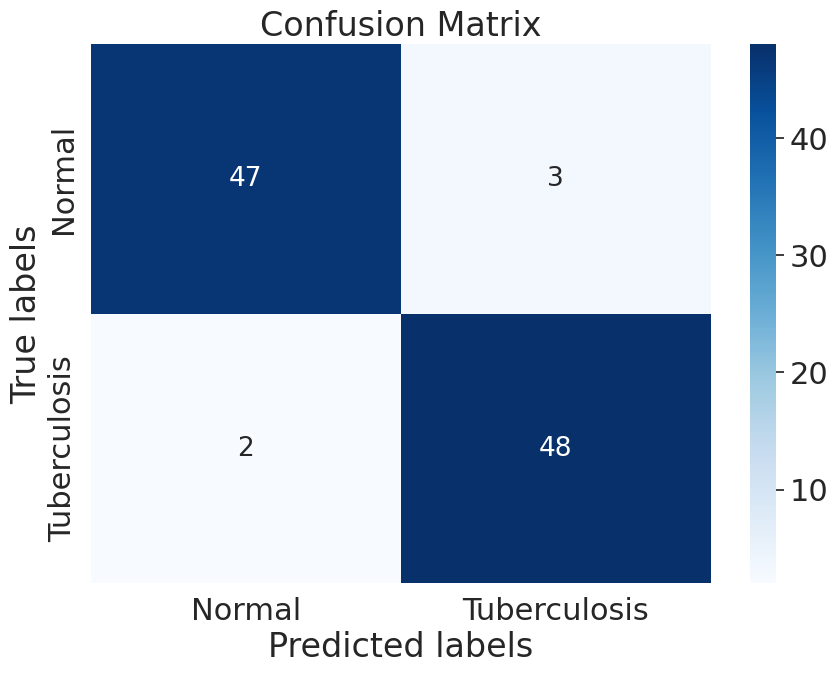

Classification Report
              precision    recall  f1-score   support

      Normal       0.96      0.94      0.95        50
Tuberculosis       0.94      0.96      0.95        50

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100



In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_input_inception

# Define the InceptionV3 model
def get_inceptionv3_model():
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model

# Compile the model
model = get_inceptionv3_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

# Training and testing the model
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.4, patience=5, min_lr=0.00001)
filepath = "InceptionV3_TB_Detection.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [reduce_lr, checkpoint]

history = model.fit(X_train, y_train, epochs=25, batch_size=16, callbacks=callbacks_list, validation_data=(X_test, y_test))
results = model.evaluate(X_test, y_test, batch_size=16)

# Predictions and evaluation
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Confusion matrix
matrix = confusion_matrix(true_classes, y_pred)
plt.figure(figsize=(10, 7))
names = ["Normal", "Tuberculosis"]
group_counts = ["{0:0.0f}".format(value) for value in matrix.flatten()]
labels = [f"{v1}" for v1 in group_counts]
labels = np.asarray(labels).reshape(2, 2)
sn.set(font_scale=2)
sn.heatmap(matrix, annot=labels, fmt='', xticklabels=names, yticklabels=names, annot_kws={"size": 19}, cmap='Blues')
plt.yticks(rotation=90)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title('Confusion Matrix')
plt.savefig('confusion_inceptionv3.png', dpi=1080)
plt.show()

# Classification report
print('Classification Report')
target_names = ['Normal', 'Tuberculosis']
print(classification_report(true_classes, y_pred, target_names=target_names))
